# Orbit determination example
This notebook does the following:
* Download an orbit first guess from SpaceTrack
* Download laser ranging data
* Feed the data to Orekit
* Estimate the orbit
* Propagate and compare the orbit to the first guess

Two types of laser ranging data can be chosen (see below):

* Normal point data: https://ilrs.cddis.eosdis.nasa.gov/data_and_products/data/npt/index.html
* Full rate data: https://ilrs.cddis.eosdis.nasa.gov/data_and_products/data/frt/index.html
    * This will improve the orbit estimation
    * Caution, this format involves large quantities of data
    * Caution 2, this data is unfiltered, therefore there can be a superposition of two range curves if two retro-reflectors on the satellite are visible by the station at the same time

## OD parameters
First, some parameters need to be defined for the orbit determination:
* Satellite ID in NORAD, COSPAR and SIC code format. These IDs can be found here: https://edc.dgfi.tum.de/en/satellites/
* Spacecraft mass: important for the drag term
* Measurement weights: used to weight certain measurements more than others during the orbit estimation. Here, we only have range measurements and we do not know the confidence associated to these measurements, so all weights are identical
* OD date: date at which the orbit will be estimated. 
* Data collection duration: for example, if equals 2 days, the laser data from the 2 days before the OD date will be used to estimate the orbit. This value is an important trade-off for the quality of the orbit determination:
    * The longer the duration, the more ranging data is available, which can increase the quality of the estimation
    * The longer the duration, the longer the orbit must be propagated, and the higher the covariance because of the orbit perturbations such as the gravity field, drag, Sun, Moon, etc.

Satellite parameters

In [1]:
sat_list = {    
    'envisat': {
        'norad_id': 27386,  # For Space-Track TLE queries
        'cospar_id': '0200901',  # For laser ranging data queries
        'sic_id': '6179',  # For writing in CPF files
        'mass': 8000.0, # kg; TODO: compute proper value
        'cross_section': 100.0, # m2; TODO: compute proper value
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },    
    'lageos2': {
        'norad_id': 22195,
        'cospar_id': '9207002',
        'sic_id': '5986',
        'mass': 405.0, # kg
        'cross_section': 0.2827, # m2
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },
    'technosat': {
        'norad_id': 42829,
        'cospar_id': '1704205',
        'sic_id': '6203',
        'mass': 20.0, # kg
        'cross_section': 0.10, # m2,
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    },
    'snet1': {
        'norad_id': 43189,
        'cospar_id': '1801410',
        'sic_id': '6204',
        'mass': 8.0, # kg
        'cross_section': 0.07,
        'cd': 2.0, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    }
}

sc_name = 'technosat'  # Change the name to select a different satellite in the dict

In [2]:
# Parameters
range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

from datetime import datetime
odDate = datetime(2020, 2, 12) # Beginning of the orbit determination
collectionDuration = 2 # days
from datetime import timedelta
startCollectionDate = odDate + timedelta(days=-collectionDuration)

# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 10.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-2
estimator_max_iterations = 25
estimator_max_evaluations = 35

## API credentials
The following sets up accounts for SpaceTrack (for orbit data) and the EDC API (for laser ranging data).
* A SpaceTrack account is required, it can be created for free at: https://www.space-track.org/auth/createAccount
* An EDC account is required, it can be created for free at: https://edc.dgfi.tum.de/en/register/

In [ ]:
# Space-Track
identity_st = input('Enter SpaceTrack username')
import getpass
password_st = getpass.getpass(prompt='Enter SpaceTrack password for account {}'.format(identity_st))
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
st = SpaceTrackClient(identity=identity_st, password=password_st)

In [ ]:
# EDC API
username_edc = input('Enter EDC API username')
password_edc = getpass.getpass(prompt='Enter EDC API password for account {}'.format(username_edc)) # You will get prompted for your password
url = 'https://edc.dgfi.tum.de/api/v1/'

## Setting up models
Initializing Orekit and JVM

In [5]:
import orekit
orekit.initVM()

# Modified from https://gitlab.orekit.org/orekit-labs/python-wrapper/blob/master/python_files/pyhelpers.py
from java.io import File
from org.orekit.data import DataProvidersManager, DirectoryCrawler
from orekit import JArray

orekit_filename = 'orekit-data'
DM = DataProvidersManager.getInstance()
datafile = File(orekit_filename)
if not datafile.exists():
    print('Directory :', datafile.absolutePath, ' not found')

crawler = DirectoryCrawler(datafile)
DM.clearProviders()
DM.addProvider(crawler)

Import station data from file

In [6]:
stationFile = 'SLRF2014_POS+VEL_2030.0_180504.snx'
stationEccFile = 'ecc_xyz.snx'
import slrDataUtils
stationData = slrDataUtils.parseStationData(stationFile, stationEccFile, startCollectionDate)

/home/yzokras/miniconda3/envs/laserod/lib/python3.8/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


The orbit determination needs a first guess. For this, we use Two-Line Elements. Retrieving the latest TLE prior to the beginning of the orbit determination. It is important to have a "fresh" TLE, because the newer the TLE, the better the orbit estimation.

In [7]:
rawTle = st.tle(norad_cat_id=sat_list[sc_name]['norad_id'], epoch='<{}'.format(odDate), orderby='epoch desc', limit=1, format='tle')
tleLine1 = rawTle.split('\n')[0]
tleLine2 = rawTle.split('\n')[1]
print(tleLine1)
print(tleLine2)

1 42829U 17042E   20042.65175483  .00000094  00000-0  14859-4 0  9990
2 42829  97.5382 290.2442 0014032 353.8494   6.2550 14.91054974140399


Setting up Orekit frames and models

In [8]:
from org.orekit.utils import Constants as orekit_constants

from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
gcrf = FramesFactory.getGCRF()
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
#itrf = FramesFactory.getITRF(ITRFVersion.ITRF_2014, IERSConventions.IERS_2010, False)
# Selecting frames to use for OD
eci = gcrf
ecef = itrf

from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ecef)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

from org.orekit.time import AbsoluteDate, TimeScalesFactory
utc = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, utc)

Setting up the propagator from the initial TLEs

In [9]:
from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(eci, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_ECI = tleOrbit_TEME.getPVCoordinates(eci)

from org.orekit.orbits import CartesianOrbit
tleOrbit_ECI = CartesianOrbit(tlePV_ECI, eci, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI,
                                               integratorBuilder, PositionAngle.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sat_list[sc_name]['mass'])
propagatorBuilder.setAttitudeProvider(nadirPointing)

Adding perturbation forces to the propagator

In [10]:
# Earth gravity field with degree 64 and order 64
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider = GravityFieldFactory.getConstantNormalizedProvider(64, 64)
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(ecef, gravityProvider)
propagatorBuilder.addForceModel(gravityAttractionModel)

# Moon and Sun perturbations
from org.orekit.forces.gravity import ThirdBodyAttraction
moon_3dbodyattraction = ThirdBodyAttraction(moon)
propagatorBuilder.addForceModel(moon_3dbodyattraction)
sun_3dbodyattraction = ThirdBodyAttraction(sun)
propagatorBuilder.addForceModel(sun_3dbodyattraction)

# Solar radiation pressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cr']);
from org.orekit.forces.radiation import SolarRadiationPressure
solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid.getEquatorialRadius(),
                                                isotropicRadiationSingleCoeff)
propagatorBuilder.addForceModel(solarRadiationPressure)

# Atmospheric drag
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
msafe = MarshallSolarActivityFutureEstimation(
    MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
    MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)
#DM.feed( MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES, msafe) # Feeding the F10.7 bulletins to Orekit's data manager

from org.orekit.models.earth.atmosphere import NRLMSISE00
atmosphere = NRLMSISE00(msafe, sun, wgs84Ellipsoid)
#from org.orekit.forces.drag.atmosphere import DTM2000
#atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
from org.orekit.forces.drag import IsotropicDrag
isotropicDrag = IsotropicDrag(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cd'])
from org.orekit.forces.drag import DragForce
dragForce = DragForce(atmosphere, isotropicDrag)
propagatorBuilder.addForceModel(dragForce)

# Relativity
from org.orekit.forces.gravity import Relativity
relativity = Relativity(orekit_constants.EIGEN5C_EARTH_MU)
propagatorBuilder.addForceModel(relativity)

Setting up the estimator

In [11]:
from org.hipparchus.linear import QRDecomposer
matrixDecomposer = QRDecomposer(1e-11)
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
optimizer = GaussNewtonOptimizer(matrixDecomposer, False)

from org.orekit.estimation.leastsquares import BatchLSEstimator
estimator = BatchLSEstimator(optimizer, propagatorBuilder)
estimator.setParametersConvergenceThreshold(estimator_convergence_thres)
estimator.setMaxIterations(estimator_max_iterations)
estimator.setMaxEvaluations(estimator_max_evaluations)

## Fetching range data
Looking for laser ranging data prior to the OD date.

The API only allows to look for data using the date formats 2018-07-1%, 2018-07-14% or 2018-07-14 0% for example. As a consequence, the search must be split into several days. The results are then sorted, and the observations which are outside of the date range are deleted.

In [12]:
import slrDataUtils
nptDatasetList = slrDataUtils.querySlrData(username_edc, password_edc, url, 'NPT',
                                         sat_list[sc_name]['cospar_id'], startCollectionDate, odDate)
frdDatasetList = slrDataUtils.querySlrData(username_edc, password_edc, url, 'FRD',
                                         sat_list[sc_name]['cospar_id'], startCollectionDate, odDate)
display(nptDatasetList)

,end_data_date,errors,incoming_date,incoming_filename,observations,satellite,start_data_date,station,status,version,wavelength
2131135,2020-02-10 02:30:18,,2020-02-10 06:27:11,nasa_202002100600.npt,13,1704205,2020-02-10 02:25:17,70900513,valid,00,532.000
2131289,2020-02-10 09:18:18,,2020-02-10 09:56:55,7840_technosat_crd_20200210_09_00.npt,6,1704205,2020-02-10 09:16:50,78403501,valid,00,532.080
2131463,2020-02-10 14:29:59,,2020-02-10 14:58:36,7237_technosat_crd_20200210_14_00.npt,3,1704205,2020-02-10 14:29:18,72371901,valid,00,532.000
2131501,2020-02-10 14:49:37,,2020-02-10 17:27:09,nasa_202002101700.npt,5,1704205,2020-02-10 14:46:11,70900513,valid,00,532.000
2131557,2020-02-10 20:55:37,,2020-02-10 21:00:58,7811_technosat_crd_20200210_20_00.npt,14,1704205,2020-02-10 20:51:09,78113802,valid,00,532.000
2131568,2020-02-10 20:58:42,,2020-02-10 22:16:30,7941_technosat_crd_20200210_2057_00.npt,3,1704205,2020-02-10 20:57:46,79417701,valid,00,532.000
2131728,2020-02-11 02:38:24,,2020-02-11 06:27:11,nasa_202002110600.npt,9,1704205,2020-02-11 02:36:01,70900513,valid,00,532.000
2131926,2020-02-11 13:21:59,,2020-02-11 17:27:09,nasa_202002111700.npt,5,1704205,2020-02-11 13:20:09,70900513,valid,00,532.000
2131900,2020-02-11 14:39:11,,2020-02-11 14:46:26,7237_technosat_crd_20200211_14_00.npt,9,1704205,2020-02-11 14:36:46,72371901,valid,00,532.000
2132259,2020-02-11 14:47:00,,2020-02-12 09:02:38,7819_technosat_crd_20200211_14_00.npt,3,1704205,2020-02-11 14:39:59,78198201,valid,00,532.000


Downloading the list of observations.

In [13]:
from orekit.pyhelpers import *
from org.orekit.estimation.measurements import Range
import slrDataUtils
nptDataFrame = slrDataUtils.dlAndParseSlrData(username_edc, password_edc, url, 'NPT', nptDatasetList)
# Comment out to download Full-Rate data
# frdDataFrame = slrDataUtils.dlAndParseSlrData(username_edc, password_edc, url, 'FRD', frdDatasetList)
display(nptDataFrame)

,station-id,range
2020-02-10 02:25:25.509469,70900513,1.333754e+06
2020-02-10 02:25:41.708771,70900513,1.229854e+06
2020-02-10 02:25:53.308286,70900513,1.157047e+06
2020-02-10 02:26:08.107685,70900513,1.066592e+06
2020-02-10 02:26:17.407314,70900513,1.011464e+06
...,...,...
2020-02-11 14:38:36.777613,72371901,9.911642e+05
2020-02-11 14:38:51.264889,72371901,1.032485e+06
2020-02-11 14:45:08.573249,78198201,1.260055e+06
2020-02-11 14:45:21.269703,78198201,1.306059e+06


Adding the measurements to the estimator

In [14]:
slrDataFrame = nptDataFrame
# Comment out to use Full-Rate data
# slrDataFrame = frdDataFrame


from org.orekit.estimation.measurements import ObservableSatellite 
observableSatellite = ObservableSatellite(0) # Propagator index = 0

for receiveTime, slrData in slrDataFrame.iterrows():
    if slrData['station-id'] in stationData.index: # Checking if station exists in the SLRF2014_POS+VEL, because it might not be up-to-date
        orekitRange = Range(stationData.loc[slrData['station-id'], 'OrekitGroundStation'], 
                            True, # Two-way measurement
                            datetime_to_absolutedate(receiveTime),
                            slrData['range'],
                            range_sigma,
                            range_weight,
                            observableSatellite
                           ) # Uses date of signal reception; https://www.orekit.org/static/apidocs/org/orekit/estimation/measurements/Range.html
        estimator.addMeasurement(orekitRange)

## Performing the OD
Estimate the orbit. This step can take a long time.

In [15]:
estimatedPropagatorArray = estimator.estimate()

## Propagating the estimated orbit

In [16]:
dt = 300.0
date_start = datetime_to_absolutedate(startCollectionDate)
date_start = date_start.shiftedBy(-86400.0)
date_end = datetime_to_absolutedate(odDate)
date_end = date_end.shiftedBy(86400.0) # Stopping 1 day after OD date

# First propagating in ephemeris mode
estimatedPropagator = estimatedPropagatorArray[0]
estimatedInitialState = estimatedPropagator.getInitialState()
actualOdDate = estimatedInitialState.getDate()
estimatedPropagator.resetInitialState(estimatedInitialState)
estimatedPropagator.setEphemerisMode()

# Propagating from 1 day before data collection
# To 1 week after orbit determination (for CPF generation)
estimatedPropagator.propagate(date_start, datetime_to_absolutedate(odDate).shiftedBy(7 * 86400.0))
bounded_propagator = estimatedPropagator.getGeneratedEphemeris()

## Covariance analysis
Creating the LVLH frame, computing the covariance matrix in both TOD and LVLH frames

In [17]:
# Creating the LVLH frame 
# It must be associated to the bounded propagator, not the original numerical propagator
from org.orekit.frames import LocalOrbitalFrame
from org.orekit.frames import LOFType
lvlh = LocalOrbitalFrame(eci, LOFType.LVLH, bounded_propagator, 'LVLH')

# Getting covariance matrix in ECI frame
covMat_eci_java = estimator.getPhysicalCovariances(1.0e-10)

# Converting matrix to LVLH frame
# Getting an inertial frame aligned with the LVLH frame at this instant
# The LVLH is normally not inertial, but this should not affect results too much
# Reference: David Vallado, Covariance Transformations for Satellite Flight Dynamics Operations, 2003
eci2lvlh_frozen = eci.getTransformTo(lvlh, actualOdDate).freeze() 

# Computing Jacobian
from org.orekit.utils import CartesianDerivativesFilter
from orekit.pyhelpers import JArray_double2D
jacobianDoubleArray = JArray_double2D(6, 6)
eci2lvlh_frozen.getJacobian(CartesianDerivativesFilter.USE_PV, jacobianDoubleArray)
from org.hipparchus.linear import Array2DRowRealMatrix
jacobian = Array2DRowRealMatrix(jacobianDoubleArray)
# Applying Jacobian to convert matrix to lvlh
covMat_lvlh_java = jacobian.multiply(
    covMat_eci_java.multiply(jacobian.transpose()))

# Converting the Java matrices to numpy
import numpy as np
covarianceMat_eci = np.matrix([covMat_eci_java.getRow(iRow) 
                              for iRow in range(0, covMat_eci_java.getRowDimension())])
covarianceMat_lvlh = np.matrix([covMat_lvlh_java.getRow(iRow) 
                              for iRow in range(0, covMat_lvlh_java.getRowDimension())])

Computing the position and velocity standard deviation 

In [18]:
pos_std_crossTrack = np.sqrt(covarianceMat_lvlh[0,0])
pos_std_alongTrack = np.sqrt(covarianceMat_lvlh[1,1])
pos_std_outOfPlane = np.sqrt(covarianceMat_lvlh[2,2])
print(f'Position std: cross-track {pos_std_crossTrack:.3e} m, along-track {pos_std_alongTrack:.3e} m, out-of-plane {pos_std_outOfPlane:.3e} m')

vel_std_crossTrack = np.sqrt(covarianceMat_lvlh[3,3])
vel_std_alongTrack = np.sqrt(covarianceMat_lvlh[4,4])
vel_std_outOfPlane = np.sqrt(covarianceMat_lvlh[5,5])
print(f'Velocity std: cross-track {vel_std_crossTrack:.3e} m/s, along-track {vel_std_alongTrack:.3e} m/s, out-of-plane {vel_std_outOfPlane:.3e} m/s')

Position std: cross-track 1.577e-01 m, along-track 8.466e-01 m, out-of-plane 3.273e-01 m
Velocity std: cross-track 8.043e-04 m/s, along-track 1.724e-04 m/s, out-of-plane 4.568e-04 m/s


## CCSDS OPM
Writing a CCSDS OPM message

In [19]:
sat_properties = {
     'mass': sat_list[sc_name]['mass'],
     'solar_rad_area': sat_list[sc_name]['cross_section'],
     'solar_rad_coeff': sat_list[sc_name]['cd'],
     'drag_area': sat_list[sc_name]['cross_section'],
     'drag_coeff': sat_list[sc_name]['cr']
}

from ccsdsUtils import Ccsds
ccsds_writer = Ccsds(originator='GOR', object_name=sc_name, object_id=sat_list[sc_name]['norad_id'], sat_properties=sat_properties)

pv_eci_init = estimatedInitialState.getPVCoordinates()
pos_eci_init = np.array(pv_eci_init.getPosition().toArray())
vel_eci_init = np.array(pv_eci_init.getVelocity().toArray())

ccsds_writer.write_opm('OPM.txt', absolutedate_to_datetime(actualOdDate), pos_eci_init, vel_eci_init, covarianceMat_eci, 'EARTH', 'GCRF')

## Analyzing residuals
Getting the estimated and measured ranges.

In [20]:
propagatorParameters   = estimator.getPropagatorParametersDrivers(True)
measurementsParameters = estimator.getMeasurementsParametersDrivers(True)

lastEstimations = estimator.getLastEstimations()
valueSet = lastEstimations.values()
estimatedMeasurements = valueSet.toArray()
keySet = lastEstimations.keySet()
realMeasurements = keySet.toArray()

from org.orekit.estimation.measurements import EstimatedMeasurement
from org.orekit.estimation.measurements import Range

import pandas as pd
observedRangeSeries = pd.Series(dtype='float64')
estimatedRangeSeries = pd.Series(dtype='float64')

for estMeas in estimatedMeasurements:
    estMeas = EstimatedMeasurement.cast_(estMeas)
    observedValue = estMeas.getObservedValue()
    estimatedValue = estMeas.getEstimatedValue()
    pyDateTime = absolutedate_to_datetime(estMeas.date)
    observedRangeSeries[pyDateTime] = observedValue[0]
    estimatedRangeSeries[pyDateTime] = estimatedValue[0]

Setting up Plotly for offline mode

In [21]:
import plotly.io as pio
#pio.renderers.default = 'jupyterlab+notebook+png'  # Uncomment for interactive plots
pio.renderers.default = 'png'

Plotting residuals

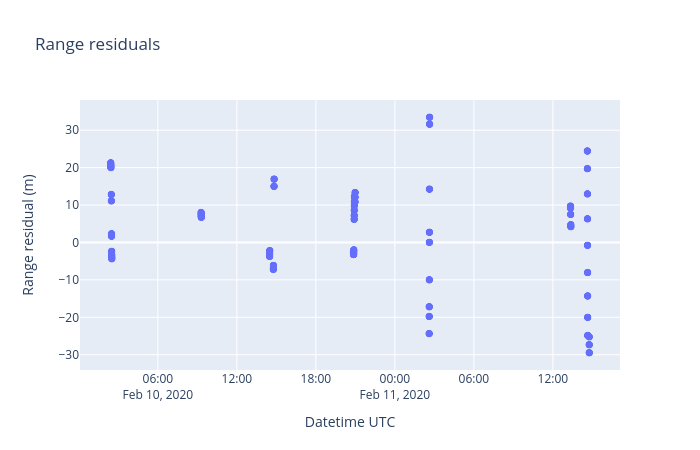

In [22]:
import plotly.graph_objs as go

trace = go.Scattergl(
    x=observedRangeSeries.index, y=observedRangeSeries-estimatedRangeSeries,
    mode='markers'
)

data = [trace]

layout = go.Layout(
    title = 'Range residuals',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Range residual (m)'
    )
)

fig = dict(data=data, layout=layout)

pio.show(fig)

## Comparison with CPF
The EDC API also provides Consolidated Prediction Files, which contain spacecraft position/velocity in ITRF frame as generated by their orbit determination system. We can compare our orbit determination with the one from the latest CPF prior to the first ranging data used in our orbit determination.

Requesting CPF data

In [23]:
from slrDataUtils import queryCpfData, dlAndParseCpfData
cpfList = queryCpfData(username_edc, password_edc, url, 
                       sat_list[sc_name]['cospar_id'], startCollectionDate - timedelta(days=1))
display(cpfList)

,end_data_date,eph_seq,errors,incoming_date,incoming_filename,provider,satellite,start_data_date,status
682126,2020-02-16 00:00:00,5401,,2020-02-09 05:15:00,technosat_cpf_200209_5401.dlr,DLR,1704205,2020-02-09 00:00:00,valid


Downloading and parsing CPF data

In [24]:
from importlib import reload
reload(slrDataUtils)
from slrDataUtils import queryCpfData, dlAndParseCpfData

In [25]:
cpfDataFrame = dlAndParseCpfData(username_edc, password_edc, url, 
                                 [cpfList.index[0]], # If several ephemerides are available for this day, only take the first
                                 startCollectionDate - timedelta(days=1),
                                 odDate + timedelta(days=1))
display(cpfDataFrame)

,x,y,z
2020-02-09 00:00:00,6014850.308,-3499568.141,604116.673
2020-02-09 00:01:00,5990627.571,-3589772.933,155782.425
2020-02-09 00:02:00,5940554.505,-3664594.643,-293209.976
2020-02-09 00:03:00,5864983.805,-3723498.345,-740963.758
2020-02-09 00:04:00,5764379.949,-3766019.979,-1185588.367
...,...,...,...
2020-02-12 23:56:00,-5604865.884,3554827.519,2110517.183
2020-02-12 23:57:00,-5428720.465,3550688.717,2534482.790
2020-02-12 23:58:00,-5229723.060,3529891.001,2947650.652
2020-02-12 23:59:00,-5008866.456,3492330.022,3348263.362


## Propagating the solution 
Propagating the solution and:
* Saving the PV coordinates from both the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the initial TLE guess.
* Computing the difference in LVLH frame between the solution and the CPF file.

In [26]:
# Propagating the bounded propagator to retrieve the intermediate states

from slrDataUtils import orekitPV2dataframe

PV_eci_df = pd.DataFrame()
PV_ecef_df = pd.DataFrame()
PV_tle_eci_df = pd.DataFrame()
deltaPV_tle_lvlh_df = pd.DataFrame(columns=['x', 'y', 'z', 'pos_norm', 'vx', 'vy', 'vz', 'vel_norm'])
deltaPV_cpf_lvlh_df = pd.DataFrame(columns=['x', 'y', 'z', 'norm'])

# Saving all intermediate
from java.util import ArrayList
states_list = ArrayList()

from org.hipparchus.geometry.euclidean.threed import Vector3D

date_current = date_start
while date_current.compareTo(date_end) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    spacecraftState = bounded_propagator.propagate(date_current)
    
    states_list.add(spacecraftState)
    
    PV_eci = spacecraftState.getPVCoordinates(eci)
    PV_eci_df = PV_eci_df.append(orekitPV2dataframe(PV_eci, datetime_current))
    
    PV_ecef = spacecraftState.getPVCoordinates(ecef)
    PV_ecef_df = PV_ecef_df.append(orekitPV2dataframe(PV_ecef, datetime_current))
    
    PV_tle_eci = sgp4Propagator.getPVCoordinates(date_current, eci)
    PV_tle_eci_df = PV_tle_eci_df.append(orekitPV2dataframe(PV_tle_eci, datetime_current))
    
    '''
    When getting PV coordinates using the SGP4 propagator in LVLH frame, 
    it is actually a "delta" from the PV coordinates resulting from the orbit determination
    because this LVLH frame is centered on the satellite's current position based on the orbit determination
    '''
    deltaPV_lvlh = sgp4Propagator.getPVCoordinates(date_current, lvlh)
    deltaPV_tle_lvlh_df.loc[datetime_current] = [deltaPV_lvlh.getPosition().getX(),
                                                 deltaPV_lvlh.getPosition().getY(), 
                                                 deltaPV_lvlh.getPosition().getZ(),
                                                 deltaPV_lvlh.getPosition().getNorm(),
                                                 deltaPV_lvlh.getVelocity().getX(),
                                                 deltaPV_lvlh.getVelocity().getY(), 
                                                 deltaPV_lvlh.getVelocity().getZ(),
                                                 deltaPV_lvlh.getVelocity().getNorm()]
    
    pos_cpf_ecef = cpfDataFrame.loc[datetime_current]
    ecef2lvlh = ecef.getTransformTo(lvlh, date_current)
    delta_pos_cpf_lvlh_vector = ecef2lvlh.transformPosition(Vector3D(float(pos_cpf_ecef[0]), float(pos_cpf_ecef[1]), float(pos_cpf_ecef[2])))
    deltaPV_cpf_lvlh_df.loc[datetime_current] = [delta_pos_cpf_lvlh_vector.getX(),
                                                 delta_pos_cpf_lvlh_vector.getY(), 
                                                 delta_pos_cpf_lvlh_vector.getZ(),
                                                 delta_pos_cpf_lvlh_vector.getNorm()]
    
    date_current = date_current.shiftedBy(dt)    

## Plotting difference between estimated orbit and CPF

Plotting position difference. The grey area represents the time window where range measurements were used to perform the orbit determination.

In [27]:
import numpy as np
import plotly.graph_objs as go

# Rectangles to visualise time window for orbit determination.

od_window_rectangle =  {
    'type': 'rect',
    # x-reference is assigned to the x-values
    'xref': 'x',
    # y-reference is assigned to the plot paper [0,1]
    'yref': 'paper',
    'x0': startCollectionDate,
    'y0': 0,
    'x1': odDate,
    'y1': 1,
    'fillcolor': '#d3d3d3',
    'opacity': 0.3,
    'line': {
        'width': 0,
    }
}

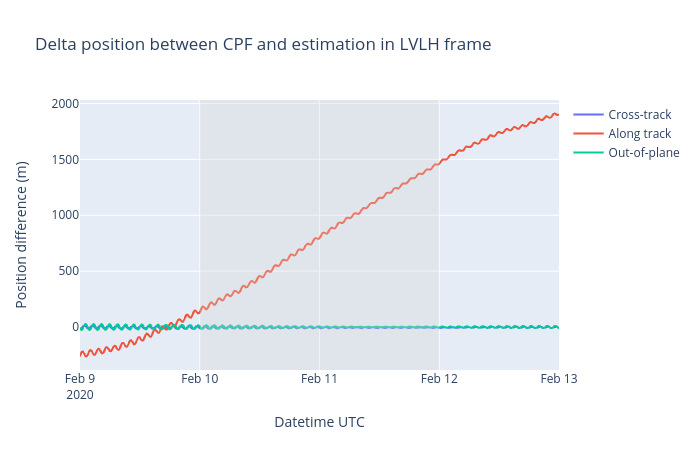

In [28]:
import plotly.graph_objs as go

traceX = go.Scattergl(
    x = deltaPV_cpf_lvlh_df.index,
    y = deltaPV_cpf_lvlh_df['x'],
    mode='lines',
    name='Cross-track'
)

traceY = go.Scattergl(
    x = deltaPV_cpf_lvlh_df.index,
    y = deltaPV_cpf_lvlh_df['y'],
    mode='lines',
    name='Along track'
)

traceZ = go.Scattergl(
    x = deltaPV_cpf_lvlh_df.index,
    y = deltaPV_cpf_lvlh_df['z'],
    mode='lines',
    name='Out-of-plane'
)

data = [traceX, traceY, traceZ]

layout = go.Layout(
    title = 'Delta position between CPF and estimation in LVLH frame',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Position difference (m)'
    ),
    shapes=[od_window_rectangle]
)

fig = dict(data=data, layout=layout)

pio.show(fig)

## Writing own CPF file

A CPF file usually contains 7 days of orbit prediction in ECEF frame with a sample time of 5 minutes, to allow the laser stations to track the satellite.

Therefore we have to propagate for 7 days.

In [29]:
# Function to compute MJD days and seconds of day
def datetime_to_mjd_days_seconds(le_datetime):
    apparent_clock_offset_s = datetime_to_absolutedate(le_datetime).offsetFrom(
        mjd_utc_epoch, utc)
    days_since_mjd_epoch = int(np.floor(apparent_clock_offset_s / 86400.0))
    seconds_of_day = apparent_clock_offset_s - days_since_mjd_epoch * 86400.0
    return days_since_mjd_epoch, seconds_of_day

In [30]:
date_end_cpf = datetime_to_absolutedate(odDate).shiftedBy(7 * 86400.0)

from slrDataUtils import orekitPV2dataframe

PV_ecef_cpf_df = pd.DataFrame()

dt = 300.0
date_current = datetime_to_absolutedate(odDate)
while date_current.compareTo(date_end_cpf) <= 0:
    datetime_current = absolutedate_to_datetime(date_current)    
    spacecraftState = bounded_propagator.propagate(date_current)
        
    PV_ecef_cpf = spacecraftState.getPVCoordinates(ecef)
    PV_ecef_cpf_df = PV_ecef_cpf_df.append(orekitPV2dataframe(PV_ecef_cpf, datetime_current))
        
    date_current = date_current.shiftedBy(dt)   
    
PV_ecef_cpf_df['mjd_days'], PV_ecef_cpf_df['seconds_of_day'] = zip(*PV_ecef_cpf_df['DateTimeUTC'].apply(lambda x: 
                                                                         datetime_to_mjd_days_seconds(x)))

In [31]:
from slrDataUtils import write_cpf
write_cpf(cpf_df=PV_ecef_cpf_df, 
          cpf_filename='cpf_out.ass', 
          ephemeris_source='ASS',  # Absolutely Serious Society
          production_date=odDate, 
          ephemeris_sequence=(odDate-datetime(2020, 1, 1)).days*10 + 5011, 
          target_name=sc_name, 
          cospar_id=sat_list[sc_name]['cospar_id'],
          sic=sat_list[sc_name]['sic_id'], 
          norad_id=str(sat_list[sc_name]['norad_id']), 
          ephemeris_start_date=odDate, 
          ephemeris_end_date=absolutedate_to_datetime(date_end_cpf), 
          step_time=int(dt))

## Comparison with TLE

Plotting the components of the position different between the TLE and the estimation, in LVLH frame. The grey area represents the time window where range measurements were used to perform the orbit determination.

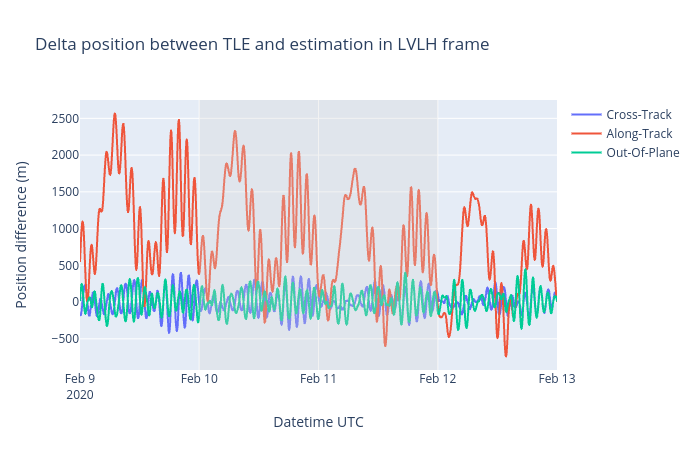

In [32]:
import plotly.graph_objs as go

traceX = go.Scattergl(
    x = deltaPV_tle_lvlh_df['x'].index,
    y = deltaPV_tle_lvlh_df['x'],
    mode='lines',
    name='Cross-Track'
)

traceY = go.Scattergl(
    x = deltaPV_tle_lvlh_df['y'].index,
    y = deltaPV_tle_lvlh_df['y'],
    mode='lines',
    name='Along-Track'
)

traceZ = go.Scattergl(
    x = deltaPV_tle_lvlh_df['z'].index,
    y = deltaPV_tle_lvlh_df['z'],
    mode='lines',
    name='Out-Of-Plane'
)

data = [traceX, traceY, traceZ]

layout = go.Layout(
    title = 'Delta position between TLE and estimation in LVLH frame',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Position difference (m)'
    ),
    shapes=[od_window_rectangle]
)

fig = dict(data=data, layout=layout)

pio.show(fig)

## Fitting an "enhanced" TLE
Let's fit a TLE to the estimated propagator. This requires the original TLE. If no TLE is available, then a first guess can be built by:

* Computing the Keplerian orbital elements from the propagator, for example using RV2COE at one instant.
* Writing these elements to the TLE. Although these elements are not mean elements, they will be fitted within a certain range.
* Write the BSTAR coefficient equal to zero. It is a free parameter in the fitting

### Fitting
Fitting the TLE, based on great example by RomaricH on the Orekit forum: https://forum.orekit.org/t/generation-of-tle/265/4

In [33]:
from org.orekit.propagation.conversion import TLEPropagatorBuilder, FiniteDifferencePropagatorConverter
from org.orekit.propagation.analytical.tle import TLEPropagator
threshold = 1.0  # "absolute threshold for optimization algorithm", but no idea about its impact
tle_builder = TLEPropagatorBuilder(orekitTle, PositionAngle.MEAN, 1.0)
fitter = FiniteDifferencePropagatorConverter(tle_builder, threshold, 1000)
fitter.convert(states_list, False, 'BSTAR')  # Setting BSTAR as free parameter
tle_propagator = TLEPropagator.cast_(fitter.getAdaptedPropagator())
tle_fitted = tle_propagator.getTLE()

Let's compare both the original and the "enhanced" TLE:

In [34]:
print(orekitTle)
print('')
print(tle_fitted)

1 42829U 17042E   20042.65175483  .00000094  00000-0  14859-4 0  9990
2 42829  97.5382 290.2442 0014032 353.8494   6.2550 14.91054974140399

1 42829U 17042E   20042.65175483  .00000000  00000-0  14711-4 0  9994
2 42829  97.5381 290.2444 0014127 354.4677   5.6311 14.91055530140392


Let us propagate again to save the PV from this new TLE

In [35]:
# Setting up yet another SGP4 propagator
sgp4Propagator_fitted = SGP4(tle_fitted, nadirPointing, sat_list[sc_name]['mass'])

In [36]:
PV_tle_fitted_eci_df = pd.DataFrame()
deltaPV_tle_fitted_lvlh_df = pd.DataFrame() # SGP4 PV from SLROD origin

date_current = date_start
while date_current.compareTo(date_end) <= 0:    
    datetime_current = absolutedate_to_datetime(date_current)
    
    PV_tle_fitted_eci = sgp4Propagator_fitted.getPVCoordinates(date_current, eci)
    PV_tle_fitted_eci_df = PV_tle_fitted_eci_df.append(orekitPV2dataframe(PV_tle_fitted_eci, datetime_current))
    
    deltaPV_tle_fitted_lvlh = sgp4Propagator_fitted.getPVCoordinates(date_current, lvlh)
    deltaPV_tle_fitted_lvlh_df = deltaPV_tle_fitted_lvlh_df.append(orekitPV2dataframe(deltaPV_tle_fitted_lvlh, datetime_current))
    
    date_current = date_current.shiftedBy(dt)    

### Comparing with estimated propagator

The individual components in LVLH frame are now more centered around zero. The fitting helped. In some cases, the fitted TLE is much better, in some cases not.

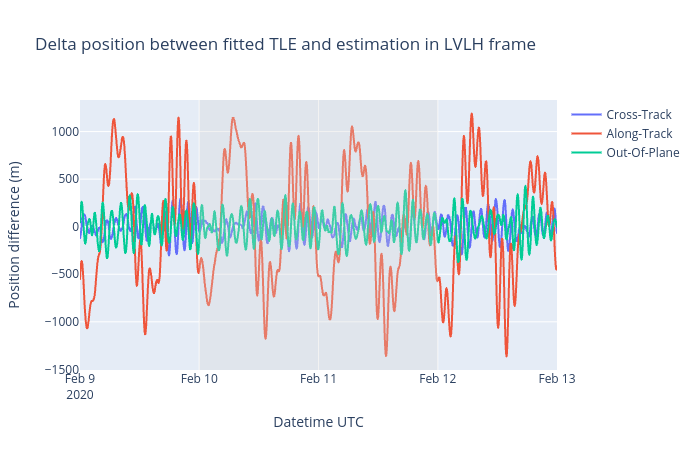

In [37]:
import plotly.graph_objs as go

traceX = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['x'].index,
    y = deltaPV_tle_fitted_lvlh_df['x'],
    mode='lines',
    name='Cross-Track'
)

traceY = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['y'].index,
    y = deltaPV_tle_fitted_lvlh_df['y'],
    mode='lines',
    name='Along-Track'
)

traceZ = go.Scattergl(
    x = deltaPV_tle_fitted_lvlh_df['z'].index,
    y = deltaPV_tle_fitted_lvlh_df['z'],
    mode='lines',
    name='Out-Of-Plane'
)

data = [traceX, traceY, traceZ]

layout = go.Layout(
    title = 'Delta position between fitted TLE and estimation in LVLH frame',
    xaxis = dict(
        title = 'Datetime UTC'
    ),
    yaxis = dict(
        title = 'Position difference (m)'
    ),
    shapes=[od_window_rectangle]
)

fig = dict(data=data, layout=layout)

pio.show(fig)